In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [4]:
import tensorflow as tf

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
tf.__version__

'1.15.0'

### load packages

In [7]:
#from tfumap.umap import tfUMAP

In [8]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


### Load dataset

In [10]:
import requests
import json
url = "https://raw.githubusercontent.com/duhaime/umap-zoo/03819ed0954b524919671a72f61a56032099ba11/data/json/bison.json"
animal = np.array(json.loads(requests.get(url).text)['3d'])
np.shape(animal)

(50000, 3)

(-1.05789, 0.98789, -0.489245, 0.660145)

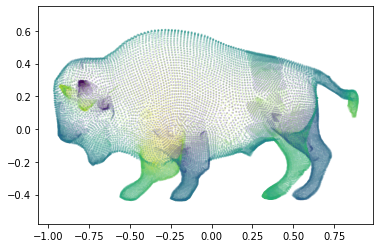

In [11]:
fig, ax = plt.subplots()
ax.scatter(animal[:,2], animal[:,1], s = 1, c = animal[:,0], alpha = 0.1)
ax.axis('equal')

In [12]:
X_train = animal
Y_train = animal[:, 2]
X_train_flat = X_train

### Create model and train

In [13]:
from scvis.run import train, map

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [14]:
from scvis.model import SCVIS

In [15]:
x = X_train_flat

In [16]:
hyperparameter =  {
  'optimization': {
    'method': 'Adam',
    'learning_rate': 0.01
  },

  'batch_size': 512,
  'max_epoch': 100,
  'regularizer_l2': 0.001,

  'perplexity': 10,

  'seed': 1
}

architecture = {
  'latent_dimension': 2,

  'inference': {
    'layer_size': [128, 64, 32],
  },

  'model': {
    'layer_size': [32, 32, 32, 64, 128],
  },

  'activation': "ELU"
}

In [17]:
architecture.update({'input_dimension': x.shape[1]})

In [18]:
model = SCVIS(architecture, hyperparameter)



Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:81:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [19]:
y = None

In [20]:
from scvis import data


In [21]:
train_data = data.DataSet(x, y)

In [22]:
es = model.train(data=train_data,
                      batch_size=hyperparameter['batch_size'],
                      verbose=True,
                      verbose_interval=50,
                      show_plot=False,
                      plot_dir=None,
                      max_iter=1000,
                      pretrained_model=None)


Batch 0
elbo: -8.866395950317383
scaled_tsne_cost: 6.24227237701416

Batch 50
elbo: -2.309149742126465
scaled_tsne_cost: 14.391789436340332

Batch 100
elbo: -0.6980333924293518
scaled_tsne_cost: 14.472086906433105

Batch 150
elbo: 0.8045060634613037
scaled_tsne_cost: 14.1591796875

Batch 200
elbo: 0.07999908924102783
scaled_tsne_cost: 13.972557067871094

Batch 250
elbo: 1.2371695041656494
scaled_tsne_cost: 13.899900436401367

Batch 300
elbo: -0.042530059814453125
scaled_tsne_cost: 13.803797721862793

Batch 350
elbo: 1.2527086734771729
scaled_tsne_cost: 13.762813568115234

Batch 400
elbo: 1.6936306953430176
scaled_tsne_cost: 14.211530685424805

Batch 450
elbo: 2.0351576805114746
scaled_tsne_cost: 13.962991714477539

Batch 500
elbo: 1.6524444818496704
scaled_tsne_cost: 14.034908294677734

Batch 550
elbo: 1.774126410484314
scaled_tsne_cost: 13.84160327911377

Batch 600
elbo: 1.741024136543274
scaled_tsne_cost: 13.819424629211426

Batch 650
elbo: 2.153318405151367
scaled_tsne_cost: 13.976

In [23]:
z, _ = model.encode(x)

### Plot model output

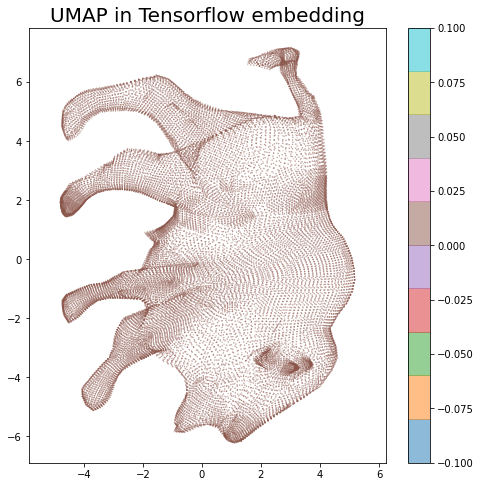

In [24]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### Save output

In [25]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [26]:
output_dir = MODEL_DIR/'projections'/ 'bison' / 'scvis'
ensure_dir(output_dir)

In [27]:
model.save_sess((output_dir / 'scvis_model').as_posix())

In [28]:
np.save(output_dir / 'z.npy', z)